In [420]:
%pylab inline

import scipy.optimize
import scipy.constants as c

# die uncertainties-Bibliothek kümmer sich um lineare ("gaußsche") Fehlerfortpflanzung
# https://github.com/lebigot/uncertainties/
import uncertainties as uc
import uncertainties.unumpy as unp

import pandas as pd

sum = __builtin__.sum

if plt.get_backend() == 'Qt5Agg':
    def figure(name, *args, **kwargs):
        # fig = FIGS[name]
        fig = plt.figure(name, *args, **kwargs)
        fig.clf()
        fig.show()
        # plt.figure(fig.number)
        return fig
else:
    def figure(name, *args, **kwargs):
        plt.close(name)
        fig = plt.figure(name)
        return fig

Populating the interactive namespace from numpy and matplotlib


In [437]:
def combine(vals):
    """kombiniert Messwerte mit korrelierten Fehlern"""
    V = uc.covariance_matrix(vals)
    inv_row_sum = solve(V, ones_like(vals, dtype=float))
    return np.dot(inv_row_sum, vals) / sum(inv_row_sum)

Konstanten

In [438]:
T = uc.ufloat(24, .5, tag='T')
p = uc.ufloat(970, 1, tag='p') * 1e2 

η = (uc.ufloat(1.849, 0.01, tag='eta') * (T - 20) + uc.ufloat(1.825, 0.01, tag='eta') * (25 - T)) / 5 * 1e-5
η * 1e5

ρ_O = ( uc.ufloat(877, .5, tag='ρ_Öl') * (25 - T) + uc.ufloat(871, .5, tag='ρ_Öl') * (T - 15) ) / 10
ρ_L = 1.20
ρ = ρ_O - ρ_L # "reduzierte" Dichte
ρ

g = 9.807 # Wert für München

# mittlere freie Weglänge
λ = uc.ufloat(67.23, 0.3, tag='λ')*1e-9 * (T + c.zero_Celsius) / (23 + c.zero_Celsius) * 1e5 / p
print(f'λ = {λ}')

d = uc.ufloat(6, .05, tag='d') * 1e-3

1.8442+/-0.008588364221433558

870.4+/-0.5431390245600093

λ = (6.954+/-0.034)e-08


In [439]:
df = pd.read_excel('ELE_Millikan.xlsx')
df.head()

U       x  t_steig  t_sink  halbzeit_sink gruppe
0  111  0.0031     45.9    17.0            NaN      A
1  111  0.0031    168.7    21.1            NaN      A
2  406  0.0031     64.4    15.4            NaN      A
3  578  0.0031     33.8    11.8            NaN      A
4  260  0.0031     13.5     9.3            NaN      A

In [440]:
# versehen Strecken mit Unsicherheit
x = (df.x[df.gruppe != 'C'] + (df.gruppe == 'A') * uc.ufloat(0, 0.1e-3, tag='x')
          + (df.gruppe == 'B') * uc.ufloat(0, 0.04e-3, tag='x')
    ).drop(where(df.gruppe == 'C')[0]) / uc.ufloat(2, 0.05, tag='linse')

# die Strecken vom Tutor habe ich in der Excel-Datei verdoppelt, also muss man sie hier halbieren 
x = x.append(df.x[df.gruppe == 'C']/2 * uc.ufloat(1, 0.02, tag='x'))

# berechne Sink-Zeiten aus ganzen Zeiten und Halbzeiten... nur das die Halbzeiten nicht berücksichtigt werden
t_sink = []
for t, t2 in zip(df.t_sink, df.halbzeit_sink):
    vals = []
    T_ERR = .25
    start_err = uc.ufloat(0, T_ERR, tag='t_start')
    if not isnan(t):
        vals.append(uc.ufloat(t, T_ERR, tag='t_end') + start_err)
    if not isnan(t2):
        vals.append((uc.ufloat(t2, T_ERR, tag='NO') + start_err) * 2)
    t_sink.append(combine(vals))
    
v_sink = x / t_sink

v_steig = - x / (df.t_steig + uc.ufloat(0, .4*sqrt(2), tag='t_steig') )
U = unp.uarray(df.U, ones_like(df.U))

Berechnen Radius und Ladung mit Cunningham-Korrektur

In [441]:
r0 = 3/2 * unp.sqrt(η * (v_steig + v_sink) / ρ / g)

A = 1.252
η_korr = η / (1 + A * λ / r0)
r_korr = unp.sqrt(r0**2 + A**2 * λ**2 / 4) - A * λ / 2

q = 3*pi * d / U * η_korr * r_korr * (v_steig - v_sink)

In [458]:
# erzeugt die Funktion zu Fitten
def make_curve(y):
    def flat(x, e):
        return np.round(unp.nominal_values(ratio)/e)*e
    return flat

ratio = - q / c.e

# zum Vergleich: Fit ohne Berücksichtigung der Korrelation
e_exp, = uc.correlated_values(*scipy.optimize.curve_fit(make_curve(ratio),
                                                      ones_like(q),
                                                      unp.nominal_values(ratio),
                                                      sigma=unp.std_devs(ratio))
                            )
print(f'falsch: {e_exp}')

# jetzt richtig
e_exp, = uc.correlated_values(*scipy.optimize.curve_fit(make_curve(ratio),
                                                      ones_like(q),
                                                      unp.nominal_values(ratio),
                                                      sigma=uc.covariance_matrix(ratio))
                            )
print(e_exp)
print(e_exp * c.e)

# a2ternative Möglichkeit
# combine(ratio / np.round(unp.nominal_values(ratio)))

savetxt('e_exp.txt', [e_exp.n, e_exp.s])

falsch: 1.046+/-0.006
1.003+/-0.027
(1.61+/-0.04)e-19


### speichere Daten um sie in Latex einzufügen

In [465]:
X = linspace(-.48, len(q) - .52, 3 * len(q))
Y = np.round(unp.nominal_values(ratio[ind].to_numpy())[asarray(np.round(X), dtype=int),])
savetxt('millikan_fit.txt', transpose([X, Y, Y * e_exp.s]), header='x y err', comments='')

In [466]:
obj = ratio.groupby(df.gruppe)
data = []
names = []
for key, grp in obj:
    savetxt(f'ratio_{key}.txt', transpose([argsort(ind)[grp.index], unp.nominal_values(grp), unp.std_devs(grp)]),
            header='n ratio err', comments='')


<Figure size 432x288 with 0 Axes>

<ErrorbarContainer object of 3 artists>

(0, 6)

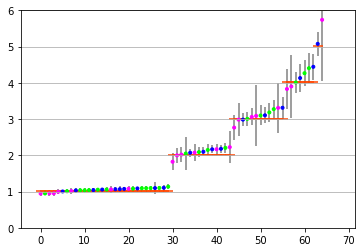

In [443]:
figure('compare')

ind = sorted(range(len(q)), key=lambda k: ratio[k].n)
plt.scatter(argsort(ind), unp.nominal_values(ratio), marker='.',
            c=list(map({'A': 'magenta', 'B': 'lime', 'C':'blue'}.__getitem__, df.gruppe)) )
plt.errorbar(argsort(ind), unp.nominal_values(ratio), yerr=unp.std_devs(ratio),
             fmt="none", marker="none", zorder=0, color='grey')
plt.ylim([0, 6])
plt.grid(axis='y')

X = arange(len(q))
fit = np.round(unp.nominal_values(ratio)/e_exp.n)*e_exp.n
plt.scatter(X, fit[ind], zorder=0, marker='_', s=100, color='orangered')

## Vergleich der unterschiedlichen Fehlerquellen

In [462]:
# gewichten die Abweichungen unter Beachtung der Korrelationen. Das läuft aufs gleiche hinaus wie fitten,
# nur dass der Fehler nicht empirisch berechnet wird
m = combine(ratio/np.round(unp.nominal_values(ratio)))
m

1.003288018570419+/-0.029969505958123043

In [461]:
vals = dict(zip({k.tag for k in m.error_components()}, it.repeat(0)))
for k, v in m.error_components().items():
    vals[k.tag] += v**2
    

print(f"t:  {(vals['t_steig'] + vals['t_start'] + vals['t_end'])/m.s**2:.1%}")
print()

for k, v in sorted(vals.items(), key=lambda x: x[1], reverse=True):
    print(f'{k}:  {v/m.s**2:.1%}')

t:  10.3%

x:  50.3%
linse:  25.1%
d:  7.8%
eta:  5.8%
t_start:  5.1%
t_end:  5.1%
T:  0.4%
None:  0.1%
t_steig:  0.1%
λ:  0.1%
ρ_Öl:  0.0%
p:  0.0%
NO:  0.0%
